# Biological Sequence Analysis using Profile Hidden Markov Models
### Machine Learning Final Project
##### Mírian Francielle da Silva

In this project I used **Hidden Markov Model** (HMM), a probabilistic model to analyze **multiple sequence alignment** (msa) of proteins.

In the model, each column of symbols in the alignment is represented by a frequency distribution of the symbols (called a "state"), and insertions and deletions are represented by other states. One moves through the model along a particular path from state to state in a Markov chain (i.e., random choice of next move), trying to match a given sequence. The next matching symbol is chosen from each state, recording its probability (frequency) and also the probability of going to that state from a previous one (the transition probability). 

State and transition probabilities are multiplied to obtain a probability of the given sequence. The hidden nature of the HMM is due to the lack of information about the value of a specific state, which is instead represented by a probability distribution over all possible values.

In [ ]:
![title]("")

In [9]:
#Python tools for computational molecular biology
%pip install biopython


The following command must be run outside of the IPython shell:

    $ pip install biopython

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [6]:
#Another Hidden Markov Model library
%pip install pomegranate


The following command must be run outside of the IPython shell:

    $ pip install pomegranate

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [10]:
#Hidden Markov Models learn library
%pip install hmmlearn


The following command must be run outside of the IPython shell:

    $ pip install hmmlearn

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [2]:
#For better visualizations
#%pip install pygraphviz

In [11]:
# Important modules 
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range, input

import argparse, sys

import matplotlib
import matplotlib as mpl
import matplotlib.style
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import Bio
import timeit

from Bio.Seq import Seq
from Bio import SeqIO
from sklearn.utils import shuffle
from scipy.io import loadmat
from scipy.stats import norm
from pomegranate import *

from hmmlearn import hmm
from multiprocessing import Pool, TimeoutError

In [12]:
print("Biopython v" + Bio.__version__)

Biopython v1.73


#### About dataset: 

The [Pfam](http://pfam.xfam.org/) database is a large collection of protein families, each represented by multiple sequence alignments and hidden Markov models (HMMs). 

[Pfam References](http://pfam.xfam.org/help?tab=helpReferencesBlock):
[The Pfam protein families database in 2019](https://academic.oup.com/nar/article/47/D1/D427/5144153): S. El-Gebali, J. Mistry, A. Bateman, S.R. Eddy, A. Luciani, S.C. Potter, M. Qureshi, L.J. Richardson, G.A. Salazar, A. Smart, E.L.L. Sonnhammer, L. Hirsh, L. Paladin, D. Piovesan, S.C.E. Tosatto, R.D. Finn
Nucleic Acids Research (2019)  doi: 10.1093/nar/gky995

__Dataset used: [Family: Miga (PF10265)](http://pfam.xfam.org/family/PF10265#alignBlock)__
Mitoguardin (Miga) was first identified in flies as a mitochondrial outer-membrane protein that promotes mitochondrial fusion. 

__Dataset used: [Family: Goblins4 (PF10265)](http://pfam.xfam.org/family/PF10265#alignBlock)__

#### About file format: 
In bioinformatics and biochemistry, the FASTA format is a text-based format for representing either nucleotide sequences or amino acid (protein) sequences, in which nucleotides or amino acids are represented using single-letter codes. The format also allows for sequence names and comments to precede the sequences.

In [41]:
input_file = "globins45.fa"

#### Parsing sequence: 

In [42]:
def fasta_reader(input_file):
    from Bio.SeqIO.FastaIO import FastaIterator
    with open(input_file) as handle:
        for record in FastaIterator(handle):
            yield record

msa = []
for entry in fasta_reader(input_file):
    msa.append(entry.seq)
    #msa_train.append(entry.seq)
    print ("ID:", str(entry.id), "\t Lenght:", str("{:,d}".format(len(entry))) ) #This is header of fasta entry
    print (repr(entry.seq), "\n") #This is sequence of specific fasta entry
    #print (str(entry.seq), "\n") #This is sequence of specific fasta entry
    
#print(msa)

ID: MYG_ESCGI 	 Lenght: 153
Seq('VLSDAEWQLVLNIWAKVEADVAGHGQDILIRLFKGHPETLEKFDKFKHLKTEAE...FQG', SingleLetterAlphabet()) 

ID: MYG_HORSE 	 Lenght: 153
Seq('GLSDGEWQQVLNVWGKVEADIAGHGQEVLIRLFTGHPETLEKFDKFKHLKTEAE...FQG', SingleLetterAlphabet()) 

ID: MYG_PROGU 	 Lenght: 153
Seq('GLSDGEWQLVLNVWGKVEGDLSGHGQEVLIRLFKGHPETLEKFDKFKHLKAEDE...FQG', SingleLetterAlphabet()) 

ID: MYG_SAISC 	 Lenght: 153
Seq('GLSDGEWQLVLNIWGKVEADIPSHGQEVLISLFKGHPETLEKFDKFKHLKSEDE...FQG', SingleLetterAlphabet()) 

ID: MYG_LYCPI 	 Lenght: 153
Seq('GLSDGEWQIVLNIWGKVETDLAGHGQEVLIRLFKNHPETLDKFDKFKHLKTEDE...FQG', SingleLetterAlphabet()) 

ID: MYG_MOUSE 	 Lenght: 153
Seq('GLSDGEWQLVLNVWGKVEADLAGHGQEVLIGLFKTHPETLDKFDKFKNLKSEED...FQG', SingleLetterAlphabet()) 

ID: MYG_MUSAN 	 Lenght: 148
Seq('VDWEKVNSVWSAVESDLTAIGQNILLRLFEQYPESQNHFPKFKNKSLGELKDTA...FQG', SingleLetterAlphabet()) 

ID: HBA_AILME 	 Lenght: 141
Seq('VLSPADKTNVKATWDKIGGHAGEYGGEALERTFASFPTTKTYFPHFDLSPGSAQ...KYR', SingleLetterAlphabet()) 

ID: HBA_PROLO 	 Lenght: 

When designing a HMM, the most important criteria are the number of states and the transitions between them.

### HMM Problems:
To analyse and describe data with HMMs, three major problems must be solved. 
- _What is the probability of an observed sequence according to a given model?_ 
This can be calculated using the forward algorithm and the result can be used, among others, to decide which model in a collection of HMMs best describes an observation.
- _The next problem is to find the most probable state sequence to have emitted an observation._
This state sequence can be used to determine the process which has caused the observation and is calculated with the Viterbi algorithm. 
- _The third problem is to optimize the model, to maximize the probabilities of given observations._
The best-known method for HMM training is the Baum-Welch, aka, Expectation Maximization training algorithm.

### Exact test performed with Viterbi algorithm, and manually entered data from an ACTG sequence.

These tests were done this way to check the alignment of a very short sequence. Because the dataset you choose has a very large string that takes a long time to run.

In [23]:
import warnings
warnings.filterwarnings('ignore')

hmm = HiddenMarkovModel()
model = HiddenMarkovModel("Global Alignment")

# Distribuição de probabilidades das inserções
insertions_distributions = DiscreteDistribution( { 'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 } )

# Criação de estados inseridos no grafo
i0 = State( insertions_distributions, name="I0" )
i1 = State( insertions_distributions, name="I1" )
i2 = State( insertions_distributions, name="I2" )
i3 = State( insertions_distributions, name="I3" )

# Criando a distribuição discreta Gaussiana de probabilidade, dos estados com "match" de simbolos
m1 = State( DiscreteDistribution({ "A": 0.95, 'C': 0.01, 'G': 0.01, 'T': 0.02 }) , name="M1" )
m2 = State( DiscreteDistribution({ "A": 0.003, 'C': 0.99, 'G': 0.003, 'T': 0.004 }) , name="M2" )
m3 = State( DiscreteDistribution({ "A": 0.01, 'C': 0.01, 'G': 0.01, 'T': 0.97 }) , name="M3" )

# Criação de estados deletados
d1 = State( None, name="D1" )
d2 = State( None, name="D2" )
d3 = State( None, name="D3" )

In [24]:
# Todos os estados inseridos no modelo HMM
#Estados que compõe a sequência, e os dados inseridos e deletados
model.add_states( [i0, i1, i2, i3, m1, m2, m3, d1, d2, d3 ] )

# Create transitions from match states
model.add_transition( model.start, m1, 0.9 )
model.add_transition( model.start, i0, 0.1 )
model.add_transition( m1, m2, 0.9 )
model.add_transition( m1, i1, 0.05 )
model.add_transition( m1, d2, 0.05 )
model.add_transition( m2, m3, 0.9 )
model.add_transition( m2, i2, 0.05 )
model.add_transition( m2, d3, 0.05 )
model.add_transition( m3, model.end, 0.9 )
model.add_transition( m3, i3, 0.1 )

In [25]:
# Create transitions from insert states
model.add_transition( i0, i0, 0.70 )
model.add_transition( i0, d1, 0.15 )
model.add_transition( i0, m1, 0.15 )

model.add_transition( i1, i1, 0.70 )
model.add_transition( i1, d2, 0.15 )
model.add_transition( i1, m2, 0.15 )

model.add_transition( i2, i2, 0.70 )
model.add_transition( i2, d3, 0.15 )
model.add_transition( i2, m3, 0.15 )

model.add_transition( i3, i3, 0.85 )
model.add_transition( i3, model.end, 0.15 )

In [26]:
# Create transitions from delete states
model.add_transition( d1, d2, 0.15 )
model.add_transition( d1, i1, 0.15 )
model.add_transition( d1, m2, 0.70 ) 

model.add_transition( d2, d3, 0.15 )
model.add_transition( d2, i2, 0.15 )
model.add_transition( d2, m3, 0.70 )

model.add_transition( d3, i3, 0.30 )
model.add_transition( d3, model.end, 0.70 )

Sequence: 'ACT'  -- Log Probability: -0.5132449003570658 -- Path: M1 M2 M3
Sequence: 'GGC'  -- Log Probability: -11.048101241343396 -- Path: I0 I0 D1 M2 D3
Sequence: 'GAT'  -- Log Probability: -9.125519674022627 -- Path: I0 M1 D2 M3
Sequence: 'ACC'  -- Log Probability: -5.0879558788604475 -- Path: M1 M2 M3


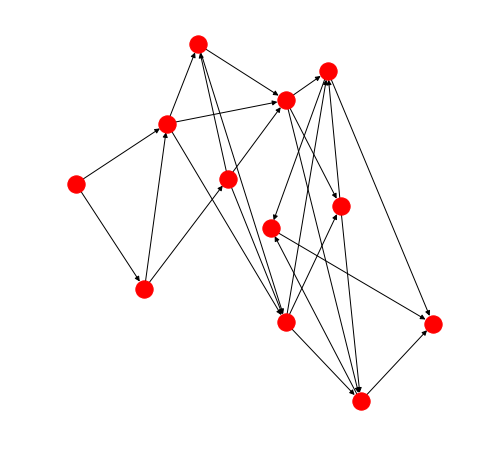

In [34]:
# Call bake to finalize the structure of the model.
model.bake()

plt.figure(figsize=(6,6))
model.plot()

for sequence in map( list, ('ACT', 'GGC', 'GAT', 'ACC') ):
    logp, path = model.viterbi( sequence )
    print ("Sequence: '{}'  -- Log Probability: {} -- Path: {}".format(''.join( sequence ), logp, " ".join( state.name for idx, state in path[1:-1] ) ))

In [35]:
for sequence in map( list, ('A', 'GA', 'AC', 'AT', 'ATCC', 'ACGTG', 'ATTT', 'TACCCTC', 'TGTCAACACT') ):
    logp, path = model.viterbi( sequence )
    print ("Sequence: '{}'  -- Log Probability: {} -- Path: {}".format(
        ''.join( sequence ), logp, " ".join( state.name for idx, state in path[1:-1] ) ))

Sequence: 'A'  -- Log Probability: -5.406181012423981 -- Path: M1 D2 D3
Sequence: 'GA'  -- Log Probability: -10.88681993576597 -- Path: I0 M1 D2 D3
Sequence: 'AC'  -- Log Probability: -3.6244718790494277 -- Path: M1 M2 D3
Sequence: 'AT'  -- Log Probability: -3.644880750680635 -- Path: M1 D2 M3
Sequence: 'ATCC'  -- Log Probability: -10.674332964640293 -- Path: M1 D2 M3 I3 I3
Sequence: 'ACGTG'  -- Log Probability: -10.393824835172445 -- Path: M1 M2 I2 I2 I2 D3
Sequence: 'ATTT'  -- Log Probability: -8.67126440174503 -- Path: M1 I1 I1 D2 M3
Sequence: 'TACCCTC'  -- Log Probability: -16.903451796110275 -- Path: I0 I0 I0 I0 D1 M2 M3 I3
Sequence: 'TGTCAACACT'  -- Log Probability: -16.451699654050792 -- Path: I0 I0 I0 I0 I0 I0 I0 M1 M2 M3


In [36]:
def path_to_alignment( x, y, path ):
    """
    This function will take in two sequences, and the ML path which is their alignment,
    and insert dashes appropriately to make them appear aligned. This consists only of
    adding a dash to the model sequence for every insert in the path appropriately, and
    a dash in the observed sequence for every delete in the path appropriately.
    """
    
    for i, (index, state) in enumerate( path[1:-1] ):
        name = state.name
        
        if name.startswith( 'D' ):
            y = y[:i] + '-' + y[i:]
        elif name.startswith( 'I' ):
            x = x[:i] + '-' + x[i:]

    return x, y

Sequence: 'A'  -- Log Probability: -5.406181012423981 -- Path: M1 D2 D3
Sequence: 'GA'  -- Log Probability: -10.88681993576597 -- Path: I0 M1 D2 D3
Sequence: 'AC'  -- Log Probability: -3.6244718790494277 -- Path: M1 M2 D3
Sequence: 'AT'  -- Log Probability: -3.644880750680635 -- Path: M1 D2 M3
Sequence: 'ATCC'  -- Log Probability: -10.674332964640293 -- Path: M1 D2 M3 I3 I3
Sequence: 'ACGTG'  -- Log Probability: -10.393824835172445 -- Path: M1 M2 I2 I2 I2 D3
Sequence: 'ATTT'  -- Log Probability: -8.67126440174503 -- Path: M1 I1 I1 D2 M3
Sequence: 'TACCCTC'  -- Log Probability: -16.903451796110275 -- Path: I0 I0 I0 I0 D1 M2 M3 I3
Sequence: 'TGTCAACACT'  -- Log Probability: -16.451699654050792 -- Path: I0 I0 I0 I0 I0 I0 I0 M1 M2 M3


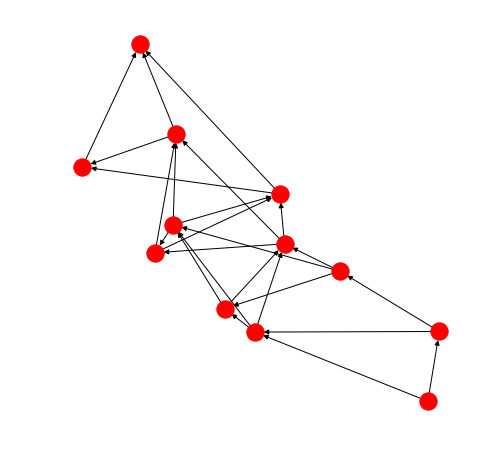

In [39]:
# Call bake to finalize the structure of the model.
model.bake()

plt.figure(figsize=(6,6))
model.plot()

for sequence in map( list, ('A', 'GA', 'AC', 'AT', 'ATCC', 'ACGTG', 'ATTT', 'TACCCTC', 'TGTCAACACT') ):
    logp, path = model.viterbi( sequence )
    print ("Sequence: '{}'  -- Log Probability: {} -- Path: {}".format(''.join( sequence ), logp, " ".join( state.name for idx, state in path[1:-1] ) ))

**The tests listed below were performed using the HMMER (see references). The dataset used was executed addressing the three problems of an HMM. The library cannot be executed directly in jupyter, because it is built in C, so I ran the test cases, right in the terminal. Listed below are the commands used for alignment, and the output of the generated file**


*hmmbuild :: profile HMM construction from multiple sequence alignments*

*input alignment file: globins4.sto*
*output HMM file: globins4.hmm*

In [43]:
%hmmbuild globins4.hmm globins4.sto

UsageError: Line magic function `%hmmbuild` not found.


In [46]:
"""
NAME  globins4
LENG  149
ALPH  amino
RF    no
MM    no
CONS  yes
CS    no
MAP   yes
NSEQ  4
EFFN  0.964844
CKSUM 2027839109
STATS LOCAL MSV       -9.9014  0.70957
STATS LOCAL VITERBI  -10.7224  0.70957
STATS LOCAL FORWARD   -4.1637  0.70957
"""

'\nNAME  globins4\nLENG  149\nALPH  amino\nRF    no\nMM    no\nCONS  yes\nCS    no\nMAP   yes\nNSEQ  4\nEFFN  0.964844\nCKSUM 2027839109\nSTATS LOCAL MSV       -9.9014  0.70957\nSTATS LOCAL VITERBI  -10.7224  0.70957\nSTATS LOCAL FORWARD   -4.1637  0.70957\n'

**The information in these lines is almost self explanatory. Globins4 alignment consisted of 4 sequences with 171 aligned columns. HMMER has transformed it into a profile of 149 consensus positions, which means it has defined 22 alignment columns containing to be consensus-related inserts.**

Below we can see whole sequence matchs, sequence scores and bias.

In [ ]:
%hmmsearch globins4.hmm uniprot_sprot.fasta > globins4.out

```
-full      -best 1 domain --- -#domE-value score bias E-value score bias exp N Sequence Description
sequence
6.7e-65    222.7   3.2   7.5e-65   222.6 3.2 1.0 1 sp|P02185|MYG_PHYCD Myoglobin OS=Physeter catodon OX=9755
3.5e-63    217.2   0.1   3.8e-63   217.0 0.1 1.0 1 sp|P02024|HBB_GORGO Hemoglobin subunit beta OS=Gorilla gor
5e-63      216.6   0.0   5.6e-63   216.5 0.0 1.0 1 sp|P68871|HBB_HUMAN Hemoglobin subunit beta OS=Homo sapien
5e-63      216.6   0.0   5.6e-63   216.5 0.0 1.0 1 sp|P68872|HBB_PANPA Hemoglobin subunit beta OS=Pan paniscu
5e-63      216.6   0.0   5.6e-63   216.5 0.0 1.0 1 sp|P68873|HBB_PANTR Hemoglobin subunit beta OS=Pan troglod
7.2e-63    216.1   3.0   8e-63     216.0 3.0 1.0 1 sp|P02177|MYG_ESCRO Myoglobin OS=Eschrichtius robustus OX

```

Note: I ended up changing the previous dataset, which was presented in the poster. Because even using HMMEr for very large sequence cases, my machine was not supporting it. And expectation maximization was taking a long time to run.

In [ ]:
#Como instalar o *hmmer*
"""
Some examples that I know of: 3 Thanks to all the people who do the
packaging!
% brew install hmmer # OS/X, HomeBrew
% port install hmmer # OS/X, MacPorts
% apt install hmmer # Linux (Ubuntu, Debian...)
% dnf install hmmer # Linux (Fedora)
% yum install hmmer # Linux (older Fedora)
% conda install -c biocore hmmer # Anaconda
"""

### Conclusion

The HMM model is widely used in this area of sequence alignment and approximation of DNA and RNA analysis, however it is an area in which I found little research, or results that I could compare to. So the dataset I ran was one that the alignment parameters are already known so I could complete the tests.